In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from pprint import pprint

from toolbox  import detach, flatten, tensor
from unidimensional import UnidimensionalGUM as GUM,\
                           UnidimensionalHMM as HMM,\
                           UnidimensionalRNN as RNN
from unidimensional import get_GUM_from_AB, sample_AB
from training import ABTrainingVisitor,               \
                     AggregateTrainingVisitor,        \
                     DefaultTrainingVisitor,          \
                     LossTrainingVisitor,             \
                     TalkativeTrainingVisitor,        \
                     parameters_estimation

# Unknown GUM

In [2]:
unknown_gum = GUM(
    a      = tensor([[.3]]),
    b      = tensor([[.9]]),
    c      = tensor([[.1]]),
    eta_   = flatten(tensor([[.7]])),
)

print(unknown_gum)

Parameters:
	> a     : tensor([[0.3000]])
	> b     : tensor([[0.9000]])
	> c     : tensor([[0.1000]])
	> eta   : tensor([[0.7000]])
	> alpha : tensor([[0.5892]])
	> beta  : tensor([[0.4330]])
A=tensor([[0.3900]]), B=tensor([[0.2601]])


## Observations generation

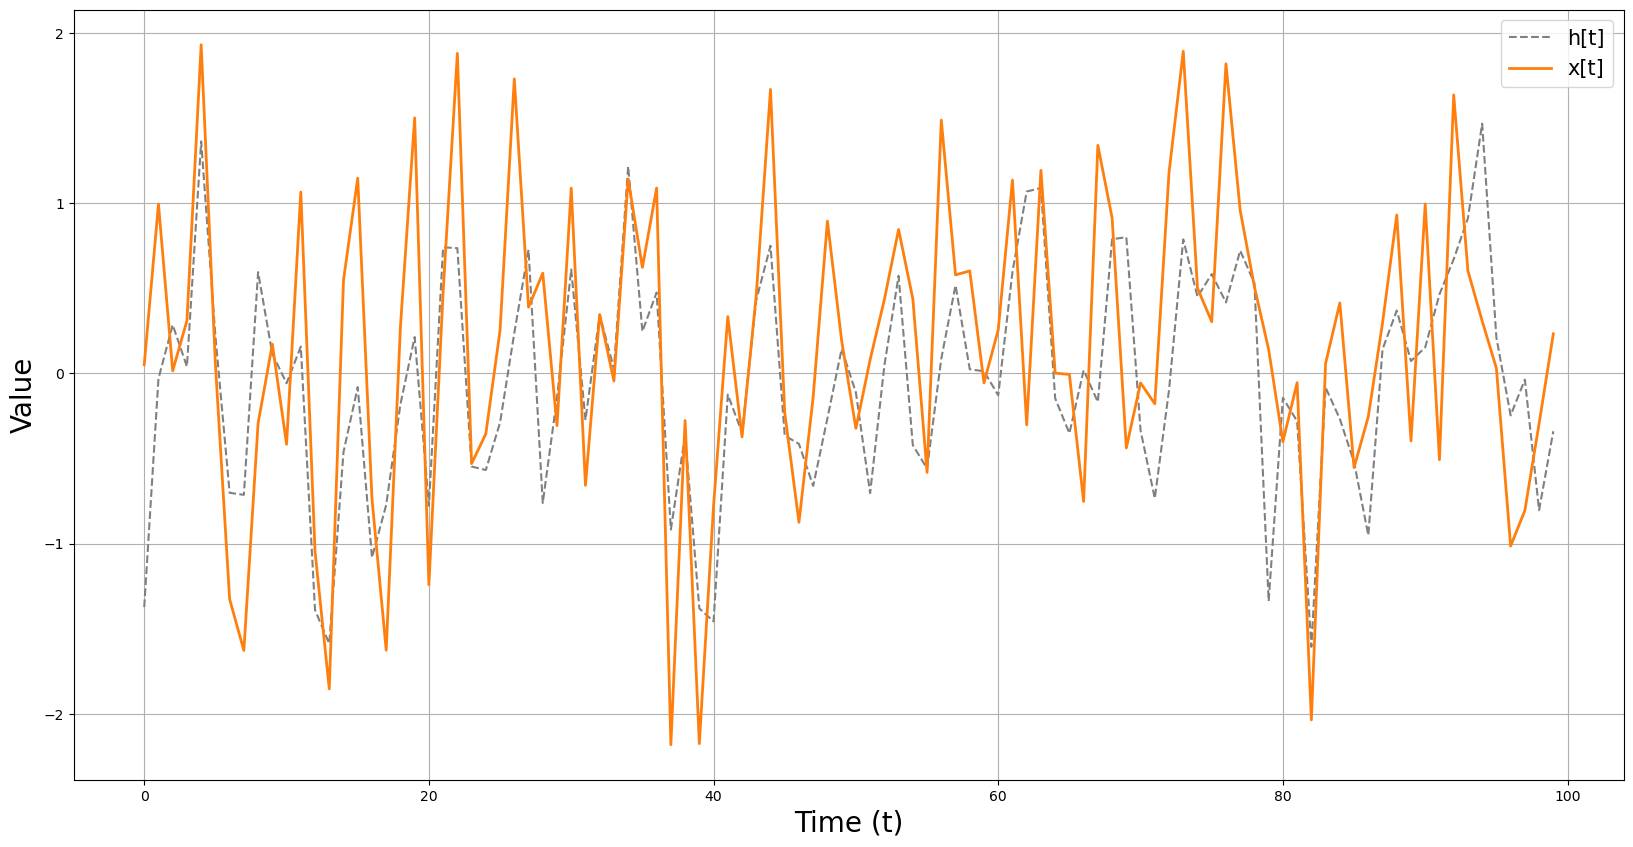

Mean: tensor([0.1517]) ; Variance: tensor([0.8260])


In [3]:
# Sample
h, x = unknown_gum.sample(100)

# Plot
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('xkcd:white')

plt.plot(list(map(lambda h: h.numpy().ravel(), h)), color="grey", linestyle="dashed", label="h[t]")
plt.plot(list(map(lambda x: x.numpy().ravel(), x)), color="C1", label="x[t]", linewidth=2)
plt.legend(fontsize=15)
plt.xlabel("Time (t)", fontsize=20)
plt.ylabel("Value"   , fontsize=20)
plt.grid()
plt.show()

print("Mean:", torch.mean(torch.cat(x, dim=0), dim=0), "; Variance:", torch.var(torch.cat(x, dim=0), dim=0))

## Derivation of the likelihood

In [4]:
# the generated suite of observation by the model itself
print("Negative log-likelihood of generated observations : {0}".format(
    detach(unknown_gum.negative_log_likelihood(x))))

# an unlikely suite (constant, equal to 42)
print("Negative log-likelihood of a constant serie       : {0}".format(
    detach(unknown_gum.negative_log_likelihood([tensor([[42]]) for _ in range(len(x))]))))

Negative log-likelihood of generated observations : 1.341776728630066
Negative log-likelihood of a constant serie       : 484.1977233886719


In [5]:
l = []
for _ in range(100):
    h, x = unknown_gum.sample(1000)
    l.append(unknown_gum.negative_log_likelihood(x).numpy()[0, 0])
    
print("Average loss: {0}; Std: {1}".format(np.mean(l), np.std(l)))

Average loss: 1.3840504884719849; Std: 0.0215945765376091


In [6]:
h, x = unknown_gum.sample(1000)

X = []

n = 100
for i in range(0, n+1):
    X.append([])
    
    B = -(i/n * 2 - 1)
    for j in range(0, n+1):
        A = (j/n * 2 - 1)
        
        if (A-1)/2 <= B and B <= (A+1)/2:
            gum = get_GUM_from_AB(A, B)
        
            X[-1].append(gum.negative_log_likelihood(x).numpy()[0, 0])
        else:
            X[-1].append(0)

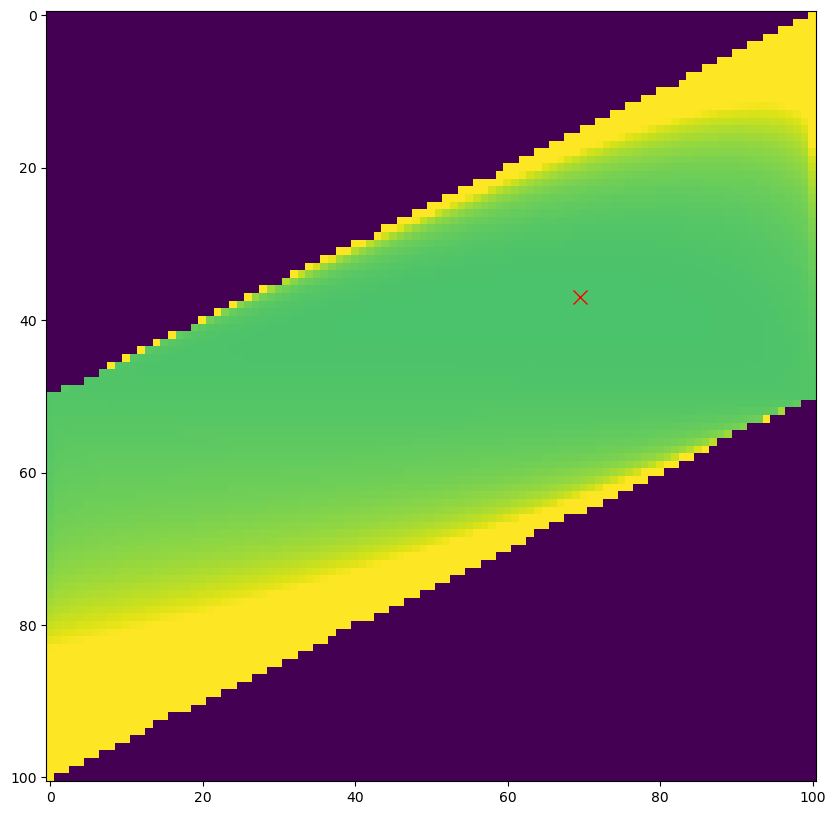

In [14]:
bound=2
X_ = np.minimum(np.array(X), bound*np.ones(np.shape(X)))

fig = plt.figure(figsize=(10, 10)) 
fig.patch.set_facecolor('xkcd:white')
ax  = fig.add_subplot(111, aspect='equal')

plt.imshow(X_)
ax.plot(
    [(1 + unknown_gum.A.detach().numpy()[0, 0]) * n/2 ], 
    [-(unknown_gum.B.detach().numpy()[0, 0] - 1) * n/2  ],
    marker="x", markersize=10, label="Unknown generator", color="red", linestyle="None"
)
plt.show()

# Parameters estimation

In [8]:
A, B = sample_AB()
print("Starting from (A={0}, B={1}).\n".format(A, B))

gum = get_GUM_from_AB(A, B, requires_grad=True)

gum = GUM(
    a      = tensor([[.1]]),
    b      = tensor([[.9]]),
    c      = tensor([[.7]]),
    eta_   = tensor([[.3]]),
    requires_grad=True
)

# gum = HMM(
#     a      = tensor([[.1]]),
#     b      = tensor([[.9]]),
#     eta_   = tensor([[.7]]),
#     requires_grad=True
# )

# gum = RNN(
#     a      = tensor([[.1]]),
#     b      = tensor([[.9]]),
#     c      = tensor([[.7]]),
#     requires_grad=True
# )

print(gum)

Starting from (A=-0.7901424091399825, B=-0.4711293213207872).

Parameters:
	> a     : tensor([[0.1000]], requires_grad=True)
	> b     : tensor([[0.9000]], requires_grad=True)
	> c     : tensor([[0.7000]], requires_grad=True)
	> eta   : tensor([[0.3000]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2308]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7570]], grad_fn=<RsubBackward1>)
A=tensor([[0.7300]]), B=tensor([[0.6543]])


In [6]:
print("RNN: expected B={0}, computed B={1}".format(gum.A * (2 * gum.A**2 - 1), gum.B))

RNN: expected B=tensor([[-0.0980]]), computed B=tensor([[0.0567]])


In [9]:
.0005*.2

0.0001

In [ ]:
loss_visitor = LossTrainingVisitor()
AB_visitor   = ABTrainingVisitor()

optimizer        = torch.optim.Adam(gum.theta, lr=.001)

def _lr_(epoch, decays=[]):
    if epoch < len(decays):
        return decays[epoch]
    else:
        return 1

scheduler        = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[.5, .2]))

gum = parameters_estimation(
    gum, 
    unknown_gum, 
    n_observations = 1000, 
    n_epochs       = 3, 
    size_batch     = 500,     
    optimizer      = optimizer,
    scheduler      = scheduler,
    visitor        = AggregateTrainingVisitor([
        AB_visitor,
        loss_visitor, 
        TalkativeTrainingVisitor()
    ])
)

> Iteration 1/1500
Parameters:
	> a     : tensor([[0.0995]], requires_grad=True)
	> b     : tensor([[0.8995]], requires_grad=True)
	> c     : tensor([[0.6995]], requires_grad=True)
	> eta   : tensor([[0.2995]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2303]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7577]], grad_fn=<RsubBackward1>)
A=tensor([[0.7287]]), B=tensor([[0.6533]])
Loss: 1.569165825843811

> Iteration 2/1500
Parameters:
	> a     : tensor([[0.0990]], requires_grad=True)
	> b     : tensor([[0.8990]], requires_grad=True)
	> c     : tensor([[0.6990]], requires_grad=True)
	> eta   : tensor([[0.2990]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2297]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7583]], grad_fn=<RsubBackward1>)
A=tensor([[0.7274]]), B=tensor([[0.6523]])
Loss: 1.6210800409317017

> Iteration 3/1500
Parameters:
	> a     : tensor([[0.0985]], requires_grad=True)
	> b     : tensor([[0.8985]], requires_grad=True)
	> c     : tensor([[0.6985]], requires_grad=Tr

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('xkcd:white')

plt.plot(loss_visitor.losses)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("log-likelihood", fontsize=20)
plt.title("Loss curve", fontsize=25)
plt.show()

In [ ]:
import matplotlib.patches as patches

As = AB_visitor.As
Bs = AB_visitor.Bs

fig = plt.figure(figsize=(10, 10)) 
fig.patch.set_facecolor('xkcd:white')
ax  = fig.add_subplot(111, aspect='equal')

# Parallelogram
x = [-1, -1, 1, 1]
y = [-1,  0, 1, 0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

# HMM
x = [0, 1, 1]
y = [0, 1, 0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

x = [0, -1, -1]
y = [0, -1,  0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

# RNN
def f(a):
    return a * (2 * a**2 - 1)

n = 100
x = [-1 + 2 * (i / n) for i in range(n + 1)]
y = list(map(f, x))
ax.plot(x, y, color = "C0")
ax.plot(x, x, color = "C0")
ax.plot(x, [0 for _ in range(len(x))], color = "C0")


# Results
ax.plot(As, Bs, color="C1")

ax.plot([As[0]], [Bs[0]],
    marker="o", markersize=7, fillstyle="none", label="Estimated GUM", color="C1")

ax.plot(
    [unknown_gum.A.detach().numpy().ravel().ravel()], 
    [unknown_gum.B.detach().numpy().ravel().ravel()],
    marker="x", markersize=10, label="Unknown generator", color="C0", linestyle="None"
)

# Show
ax.legend()
ax.set_xlabel("A", fontsize=20)
ax.set_ylabel("B", fontsize=20)
ax.set_title("Parameters estimation with regard to\nthe parallelogram (unidimensional case)", fontsize=25)
plt.show()